# Question 3.1) RNN for Text Classification
Instructions: *Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).*

Below is my RNN model to solve the classification task.

In [44]:
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from keras.layers import Dense, SimpleRNN, LSTM, Embedding
from keras.layers import Input, Conv2D, MaxPooling2D, MaxPool2D, GlobalMaxPooling1D
from keras.layers import UpSampling2D, Dropout, Activation, Flatten
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf
import keras
import numpy as np
from keras.utils import np_utils
%matplotlib inline
from matplotlib import pyplot as plt
from keras import regularizers
from string import printable
from keras.callbacks import TensorBoard
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

**Preprocess the URLs. **

In [45]:
#First, we open the malicious-urls file and parse the URLs. 
malicious_urls_file = open("malicious-urls.txt")
malicious_urls_list = [url.strip() for url in malicious_urls_file]

In [46]:
#Now, we open the benign-urls file and parse its URLs.
benign_urls_file = open("benign-urls.txt")
benign_urls_list = [url.strip() for url in benign_urls_file]

In [47]:
#Concatenate both the malicious and the benign urls to form our training data. 
urls = malicious_urls_list + benign_urls_list
malicious_urls_labels = [1] * len(malicious_urls_list) #assign 1 to the labels of the malicious urls.
benign_urls_labels = [0] * len(benign_urls_list)       #assign 0 to the labels of the benign urls.

Y = malicious_urls_labels + benign_urls_labels
Y = np.array(Y)

In [48]:
from keras.preprocessing.sequence import pad_sequences
from string import printable

**Convert the urls to integer representations.**

In [49]:
#Convert the urls to integer representations, using their index in 'printable', which lists
#all of the ASCII characters that we can print. 
#Also, we will find the maximum url length so that we can pad all urls to its size. 
url_int_representation = []
max_url_length = 0

for url in list(urls):
    url_chars = []
    for char in url:
        #url_chars.append(ord(char) % len(printable))
        url_chars.append(printable.index(char))
    if len(url_chars) > 0:
        url_int_representation.append(url_chars)
    if len(url_chars) > max_url_length:
        max_url_length = len(url_chars) #Keep track of the length of the longest URL.

In [50]:
#Pad all the urls to the longest url, for consistency.
print("max_url_length:", max_url_length)
X = pad_sequences(url_int_representation, maxlen = max_url_length)
X = np.array(X)

max_url_length: 86


In [51]:
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)

X.shape: (67353, 86)
Y.shape: (67353,)


In [52]:
#Split data into training and testing set. 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = 0)


In [53]:
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_train.shape:", Y_train.shape)
print("Y_test.shape:", Y_test.shape)

X_train.shape: (50514, 86)
X_test.shape: (16839, 86)
Y_train.shape: (50514,)
Y_test.shape: (16839,)


In [54]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


**Create the RNN model for binary classification. **

In [55]:
#Define the layers for the RNN model. 

#getting size of all the characters we can print out -- the size of our vocab.
vocab_size = len(printable) 

#Adding the input layer.
input_layer = Input(shape=(max_url_length, ), dtype='int32')

#Adding the embedding layer.
embedding_layer = Embedding(input_dim = vocab_size, output_dim = 32, input_length = max_url_length, dropout=0.2, W_regularizer = regularizers.l2(1e-4))(input_layer) 

#Adding the Simple RNN layer with dropout to prevent overfitting.
rnn_layer = SimpleRNN(32)(embedding_layer) 
rnn_layer = Dropout(0.5)(rnn_layer)

#Adding the output layer with the sigmoid activiation function for binary classification.
output_layer = Dense(1, activation='sigmoid')(rnn_layer)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=100, output_dim=32, input_length=86, embeddings_regularizer=<keras.reg...)`
  app.launch_new_instance()


**Run the RNN model over 10 epochs.**

In [56]:
#Creating the RNN model now using the layers we defined above. 
rnn_model = Model(input = [input_layer], output = [output_layer])
rnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 86)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 86, 32)            3200      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  


In [57]:
#Compile and run model with binary cross entropy (since we're using binary classification), and momentum with adam optimizer over 10 epochs.
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
report = rnn_model.fit(X_train, Y_train, epochs = 10, shuffle = True, validation_data = (X_test, Y_test), batch_size = 32, callbacks = [TensorBoard(log_dir='/tmp/RNN_Classification')] )


Train on 50514 samples, validate on 16839 samples
Epoch 1/10
50514/50514 [==============================] - 50s 988us/step - loss: 0.0845 - acc: 0.9800 - val_loss: 0.0530 - val_acc: 0.9825
Epoch 2/10
50514/50514 [==============================] - 50s 998us/step - loss: 0.0407 - acc: 0.9852 - val_loss: 0.0249 - val_acc: 0.9887
Epoch 3/10
50514/50514 [==============================] - 48s 947us/step - loss: 0.0287 - acc: 0.9878 - val_loss: 0.0319 - val_acc: 0.9863
Epoch 4/10
50514/50514 [==============================] - 48s 949us/step - loss: 0.0267 - acc: 0.9886 - val_loss: 0.0226 - val_acc: 0.9893
Epoch 5/10
50514/50514 [==============================] - 48s 942us/step - loss: 0.0259 - acc: 0.9888 - val_loss: 0.0234 - val_acc: 0.9891
Epoch 6/10
50514/50514 [==============================] - 50s 1000us/step - loss: 0.0259 - acc: 0.9890 - val_loss: 0.0278 - val_acc: 0.9889
Epoch 7/10
50514/50514 [==============================] - 51s 1ms/step - loss: 0.0245 - acc: 0.9895 - val_loss: 0.0

**Calculate the RNN model's accuracy and loss over the training and testing set.**

In [84]:
#Calculate the model's accuracy and loss over the training and testing set. 
training_loss_accuracy = rnn_model.evaluate(X_train, Y_train, verbose=0)
print('Training Loss:', training_loss_accuracy[0])
print("Training accuracy:", training_loss_accuracy[1])

testing_loss_accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)
print('\nTesting Loss:', testing_loss_accuracy[0])
print("Testing accuracy:", testing_loss_accuracy[1])

Training Loss: 0.019366887285045816
Training accuracy: 0.9915468978802543

Testing Loss: 0.023210817436562434
Testing accuracy: 0.9892511431795237


# Question 3.2) CNN for Text Classification

Instructions: *Build and train a 1D CNN for this text classification task.*

Below, is my CNN model to solve this classification task. 

**Preprocess the URLs.**

In [62]:
#First, we open the malicious-urls file and parse the URLs. 
malicious_urls_file = open("malicious-urls.txt")
malicious_urls_list = [url.strip() for url in malicious_urls_file]

In [63]:
benign_urls_file = open("benign-urls.txt")
benign_urls_list = [url.strip() for url in benign_urls_file]

In [64]:
#Concatenate both the malicious and the benign urls to form our training data. 
urls = malicious_urls_list + benign_urls_list
malicious_urls_labels = [1] * len(malicious_urls_list) #assign 1 to the labels of the malicious urls.
benign_urls_labels = [0] * len(benign_urls_list)       #assign 0 to the labels of the benign urls.

Y = malicious_urls_labels + benign_urls_labels
Y = np.array(Y)

**Convert the urls to integer representations.**

In [65]:
#Convert the urls to integer representations, using their index in 'printable', which lists
#all of the ASCII characters that we can print. 
#Also, we will find the maximum url length so that we can pad all urls to its size. 
url_int_representation = []
max_url_length = 0

for url in list(urls):
    url_chars = []
    for char in url:
        #url_chars.append(ord(char))
        url_chars.append(printable.index(char))
    if len(url_chars) > 0:
        url_int_representation.append(url_chars)
    if len(url_chars) > max_url_length:
        max_url_length = len(url_chars)

In [66]:
#Pad X so that all of the url sequences are of the same length.
X = pad_sequences(url_int_representation, maxlen = max_url_length)
X = np.array(X)

In [67]:
#Split X into the training set and testing set. 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = 0)

In [68]:
#Print out the shapes of the training and testing data.
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_train.shape:", Y_train.shape)
print("Y_test.shape:", Y_test.shape)

X_train.shape: (50514, 86)
X_test.shape: (16839, 86)
Y_train.shape: (50514,)
Y_test.shape: (16839,)


In [69]:
#Constants for building the CNN model. 
vocab_size = len(printable) #100
embedding_dimension = 32
epochs = 100
batch_size = 32 
kernel_size = 3
number_filters = 64

**Create the CNN model for the binary classification.**

In [70]:
#Create the CNN model for the binary classification.
cnn_model = Sequential()

#First, add an embedding layer which links the indices of the vocab into the embedding_dimension.
#Then, we introduce dropout to prevent overfitting.
cnn_model.add(Embedding(vocab_size, embedding_dimension, input_length = max_url_length))
cnn_model.add(Dropout(0.3)) 

In [71]:
#Secondly, add a Convolution1D for learning the filters.
#We use a stride of 1 and do not use padding. The feature detector is of size 3x3 with a stride of 1.
cnn_model.add(Conv1D(number_filters, kernel_size, padding='valid', activation='relu', strides=1))

In [72]:
#Add in globalmaxpooling1D to take the max vector over the steps dimension. 
cnn_model.add(GlobalMaxPooling1D())

In [73]:
#Setting up the dense layer with 300 neurons.
#Then, we introduce dropout to prevent overfitting.
cnn_model.add(Dense(300))   
cnn_model.add(Dropout(0.3))   
cnn_model.add(Activation('relu'))

In [74]:
#Setting up the output layer, which is sigmoid as we are using binary classification.
cnn_model.add(Dense(1))
cnn_model.add(Activation('sigmoid'))

**Run CNN model over 10 epochs.**

In [77]:
#Use binary cross entropy as the loss function, and use momentum with the adam optimizer. 
#Train the model over 50 epochs.
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
report = cnn_model.fit(X_train, Y_train, epochs = 10, shuffle = True, validation_data = (X_test, Y_test), batch_size = 32, callbacks = [TensorBoard(log_dir='/tmp/CNN_Classification')] )


Train on 50514 samples, validate on 16839 samples
Epoch 1/10
50514/50514 [==============================] - 21s 425us/step - loss: 0.0428 - acc: 0.9831 - val_loss: 0.0261 - val_acc: 0.9872
Epoch 2/10
50514/50514 [==============================] - 22s 430us/step - loss: 0.0314 - acc: 0.9861 - val_loss: 0.0227 - val_acc: 0.9898
Epoch 3/10
50514/50514 [==============================] - 21s 419us/step - loss: 0.0271 - acc: 0.9878 - val_loss: 0.0207 - val_acc: 0.9900
Epoch 4/10
50514/50514 [==============================] - 21s 408us/step - loss: 0.0238 - acc: 0.9892 - val_loss: 0.0192 - val_acc: 0.9905
Epoch 5/10
50514/50514 [==============================] - 22s 432us/step - loss: 0.0220 - acc: 0.9905 - val_loss: 0.0190 - val_acc: 0.9908
Epoch 6/10
50514/50514 [==============================] - 22s 438us/step - loss: 0.0214 - acc: 0.9904 - val_loss: 0.0183 - val_acc: 0.9917
Epoch 7/10
50514/50514 [==============================] - 22s 428us/step - loss: 0.0214 - acc: 0.9908 - val_loss: 0.

**Calculate the model's accuracy and loss over the training and testing set.**

In [83]:
#Calculate the model's accuracy and loss over the training and testing set. 
training_loss_accuracy = cnn_model.evaluate(X_train, Y_train, verbose=0)
print('Training Loss:', training_loss_accuracy[0])
print("Training accuracy:", training_loss_accuracy[1])

testing_loss_accuracy = cnn_model.evaluate(X_test, Y_test, verbose=0)
print('\nTesting Loss:', testing_loss_accuracy[0])
print("Testing accuracy:", testing_loss_accuracy[1])

Training Loss: 0.0120665177303727
Training accuracy: 0.9948331155719207

Testing Loss: 0.016885618429664285
Testing accuracy: 0.9920422827958905


# Question 3.3) ROC/AUC Analysis

In [79]:
cnn_model_y_pred = cnn_model.predict(X_test).ravel()
fpr_cnn_model, tpr_cnn_model, thresholds_cnn_model = roc_curve(Y_test, cnn_model_y_pred)

rnn_model_y_pred = rnn_model.predict(X_test).ravel()
fpr_rnn_model, tpr_rnn_model, thresholds_rnn_model = roc_curve(Y_test, rnn_model_y_pred)

In [80]:
auc_cnn_model = auc(fpr_cnn_model, tpr_cnn_model)
auc_rnn_model = auc(fpr_rnn_model, tpr_rnn_model)

**ROC/AUC Analysis for both the CNN and LSTM models for this binary classification task.**

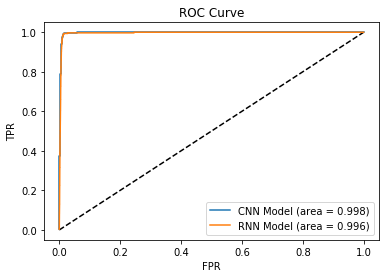

In [81]:
#ROC/AUC Analysis for both the CNN and RNN models for this binary classification task.
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn_model, tpr_cnn_model, label='CNN Model (area = {:.3f})'.format(auc_cnn_model))
plt.plot(fpr_rnn_model, tpr_rnn_model, label='RNN Model (area = {:.3f})'.format(auc_rnn_model))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

**Zooming in at the top left corner, for a closer look.**

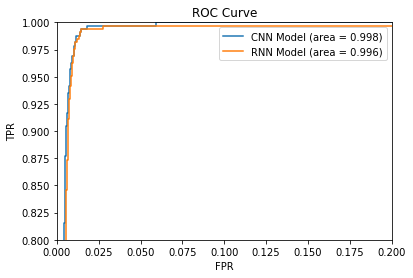

In [87]:
#Zooming in at the top left corner, for a closer look. 
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn_model, tpr_cnn_model, label='CNN Model (area = {:.3f})'.format(auc_cnn_model))
plt.plot(fpr_rnn_model, tpr_rnn_model, label='RNN Model (area = {:.3f})'.format(auc_rnn_model))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Above, we plotted the ROC curve for both the RNN and the CNN models for binary classification. It would seem that the two models perform very well, although it seems that the CNN model does a slightly job at predicting malicious urls as opposed to the RNN model. With that being said, it is worth pointing out that these results are based on how the hyperparameters were tuned. If the hyperparameters are retuned, then the results could be different. In this problem, I trained both the CNN and RNN with the same batch size and number of epochs. 